In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))
main_dir = os.path.abspath('..')
os.chdir(main_dir)
sys.path.append(main_dir)

import numpy as np
import sympy as sp
import re, copy, tqdm
from sklearn.model_selection import train_test_split
from PhysicsRegression import PhyReg

### Step1: Load Plasma Pressure data

The Plasma Pressure Data contains 12 datasets of different Kp (Kp=0,1,2,3,4,5) and Pd (Pd=1.5,3.0).
We first transform the data from Cartesian Coordinates to Polar Coordinates, using the data with r<28 for training.

In [2]:
x_to_fit = []
y_to_fit = []
units = []

x_total = []
y_total = []

for Kp in ["0", "1", "2", "3", "4", "5"]:
    for Pd in ["1.5", "3.0"]:
        with open(f"./data/physics_data/TH-Gt_beta-ge-0.1_Kp={Kp}_Pd={Pd}_50-quartile.txt", "r") as fi:
            context = [c.split() for c in fi.read().split("\n")][1:-1]

        x = np.array([
            [float(c[0]) for c in context],
            [float(c[1]) for c in context]
        ]).transpose()
        y = np.array([float(c[6]) for c in context]).reshape((-1, 1))

        idx_nan = (y < 1e-10).reshape((-1))
        x = x[~idx_nan]
        y = y[~idx_nan]

        idx_pos = (x[:, 0] > 0).reshape((-1))
        x = x[~idx_pos]
        y = y[~idx_pos]

        x_total.append(copy.deepcopy(x))
        y_total.append(copy.deepcopy(y))

        x[:,0] = - x[:,0]                           #should be [0, 40]
        x[:,1] = x[:,1]                             #should be [-20, 20]

        x_polar = np.array([
            np.sqrt(x[:,0]**2 + x[:,1]**2) / 8,     #should be [0, 5]
            np.arctan2(x[:,1], x[:,0])              #should be [-pi/2, pi/2]
        ]).transpose()

        x_polar[:,1] = x_polar[:,1] + np.pi / 2     #should be [0, pi]
        
        assert all(0 <= x_polar[:,0]) and all(x_polar[:,0] <= 10)
        assert all(0 <= x_polar[:,1]) and all(x_polar[:,1] <= np.pi)

        x_to_fit.append(x_polar)
        y_to_fit.append(y)

for i in range(len(x_to_fit)):
    x_train, x_test, y_train, y_test = train_test_split(x_to_fit[i], y_to_fit[i], test_size=0.1, random_state=2024)
    x_to_fit[i] = x_train
    y_to_fit[i] = y_train

_x_to_fit = []
_y_to_fit = []
for j in [3.5]:
    for i in range(len(x_to_fit)):
        train_idx = x_to_fit[i][:, 0] < j
        x_train = x_to_fit[i][train_idx]
        y_train = y_to_fit[i][train_idx]
        _x_to_fit.append(x_train)
        _y_to_fit.append(y_train)
x_to_fit = _x_to_fit
y_to_fit = _y_to_fit

### Step2: Inference with PhyReg

In [3]:
np.random.seed(2024)

phyreg = PhyReg(
    path = "./model.pt",
    max_len=1000,
)

phyreg.fit(
    x_to_fit, y_to_fit, 
    use_Divide=True, 
    use_MCTS=False, 
    use_GP=False, 
    use_pysr_init=False, 
    use_const_optimization=False,
    verbose=False,
    oracle_name="physical2",
    oracle_file="./physical/data/oracle_model_case2/",
    oracle_bs=64, oracle_lr=0.004, oracle_epoch=1000,
    use_seperate_type=["id"],
    save_oracle_model=True
)

The symbolic formulas of 12 datasets are not totally the same, we hope to extract a unified symbolic formula and simultaneously optimize the constants.

In [ ]:
np.random.seed(2024)
num_bfgs = 600

current_refined_exprs = []      # 12 list (12 formulas)
current_refined_mses = []       # 12 mses

pbar = tqdm.tqdm(total = 12 * 12 * num_bfgs)

for i in range(12):

    current_refined_expr = []   # 12 formulas
    current_refined_mse = 0     # 1 mses

    for j in range(12):

        best_expr = ""
        best_mse = 1e10

        expr = str(phyreg.best_gens[i]["predicted_tree"])
        expr = expr.replace("x_0", "(x_0 - 0.0)")
        expr = expr.replace("x_1", "(x_1 * 1.0)")
        for k,v in {
            "add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/", "neg": "-"
        }.items():
            expr = expr.replace(k, v)

        consts = re.findall(r"[+-]?\b\d+\.\d+\b", expr)
        for t,c in enumerate(consts):
            expr = expr.replace(c, f"c_{t}", 1)
        consts = np.array(list(map(float, consts)))

        x = x_to_fit[j]; y = y_to_fit[j]

        for trial in range(num_bfgs):
            
            if len(consts) > 9: pbar.update(1); continue
            new_consts = copy.deepcopy(consts)
            new_consts = new_consts + np.random.normal(0, 0.5, new_consts.shape)
            new_expr = copy.deepcopy(expr)

            new_consts = phyreg._const_optimize(f"log({new_expr})", (x, np.log(y)), len(consts), new_consts)
            for t,c in enumerate(new_consts):
                new_expr = new_expr.replace(f"c_{t}", str(c), 1)
            
            x_variables = [sp.Symbol('x_{}'.format(t)) for t in range(2)]
            f = sp.lambdify(x_variables, new_expr, "numpy")
            pred = f(*x.T)
            mse = phyreg.eval_metric(np.log(y), np.log(pred), metric="mse")

            if mse < best_mse:
                best_mse = mse
                best_expr = new_expr

            pbar.update(1)
    
        current_refined_expr.append(best_expr)
        current_refined_mse += best_mse

    current_refined_exprs.append(current_refined_expr)
    current_refined_mses.append(current_refined_mse)

pbar.close()

idx = np.argmin(current_refined_mses)
refined_exprs = current_refined_exprs[idx]

phyreg.express_skeleton(
    [{"predicted_tree":refined_exprs[i]} for i in range(len(refined_exprs))],
    use_sp=True
)

  0%|          | 0/86400 [00:00<?, ?it/s]

100%|██████████| 86400/86400 [29:13<00:00, 49.28it/s]   

idx          : 0
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 + C_5) - C_6))
constants    : 0.046 7.83 0.083 -2.776 1.02 11.026 7.599

idx          : 1
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 - C_5) - C_6))
constants    : 0.099 8.972 0.031 -1.745 1.455 8.469 7.158

idx          : 2
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 + C_5) - C_6))
constants    : 0.117 3.632 0.331 -0.828 0.265 5.261 7.27

idx          : 3
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 - C_5) - C_6))
constants    : 0.175 4.085 0.323 1.097 2.192 12.715 6.959

idx          : 4
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 - C_5) - C_6))
constants    : 0.079 5.21 0.287 0.658 1.903 6.434 7.503

idx          : 5
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 + C_5) - C_6))
constants    : 0.142 6.749 0.226 0.779 1.684 6.651 6.493

idx          : 6
expr skeleton: C_0 - C_1/((x_0 - C_2)**2*(C_3*cos(C_4*x_1 + C_5) - C_6))
constants    : 0.054 

### Step3: plot the predicted formula

In [18]:
pred_func = [
    "(0.036827635033091465 + (0.020893919956956438 * (0.3758678559136228 * 1/((((x_0 - 0.16410799584846221))**2 * (cos(0.015340711204773696 * x_1) + -0.990678309143886))))))",
    "(0.06165377710958919 + (-1.2491182310849456 * (-0.0015298200720535436 * 1/((((x_0 - 0.08334078083498454))**2 * (cos(0.007051200491736382 * x_1) + -0.9984260972911366))))))",
    "(0.027988540594940235 + (6.331592353782785 * (10.115385918841282 * 1/((((x_0 - 0.05223582216373519))**2 * (cos(5.430105257116753 * x_1) + 60.90638263903331))))))",
    "(0.06536218486580939 + (7.033372052881372 * (11.626916199376675 * 1/((((x_0 - -0.06451274303403289))**2 * (cos(5.466671696520451 * x_1) + 53.86611381070727))))))",
    "(0.06130127569956305 + (2.548923010953542 * (2.2250524368449227 * 1/((((x_0 - 0.2718693716972257))**2 * (cos(2.0106957650733656 * x_1) + 6.4739422667677635))))))",
    "(0.1081552982317302 + (12.139136737869832 * (5.767090455237469 * 1/((((x_0 - 0.1959067910679289))**2 * (cos(3.507374062211554 * x_1) + 59.8860430778639))))))",
    "(0.04591735626810193 + (4.339806057566353 * (6.915764801768054 * 1/((((x_0 - 0.19087499406391906))**2 * (cos(3.4956040557940593 * x_1) + 29.32510211834719))))))",
    "(0.08130986410965187 + (5.236827195555356 * (8.460045320326318 * 1/((((x_0 - 0.0906043507058652))**2 * (cos(3.7528451259116946 * x_1) + 26.953322467166146))))))",
    "(0.05381435434375163 + (4.776802214002857 * (5.663676945289391 * 1/((((x_0 - 0.22778576521797272))**2 * (cos(3.931404404108106 * x_1) + 25.713503037909305))))))",
    "(0.09223584502648778 + (5.969700109644645 * (5.916344208820552 * 1/((((x_0 - 0.11902166507385573))**2 * (cos(4.006161367301317 * x_1) + 20.498408624529628))))))",
    "(0.06475739787397806 + (2.4341513333550044 * (6.071295401700626 * 1/((((x_0 - 0.32060052192595445))**2 * (cos(4.116306920089865 * x_1) + 14.996621517953415))))))",
    "(0.11227950763700374 + (4.117980352698021 * (4.850317306641288 * 1/((((x_0 - 0.24094863552251267))**2 * (cos(4.122240581329033 * x_1) + 12.821792529606155))))))",
]

#pred_func = copy.deepcopy(current_refined_exprs[-1])

x_variables = [sp.Symbol('x_{}'.format(k)) for k in range(2)]
for i in range(len(pred_func)):
    pred_func[i] = pred_func[i].replace("x_0", f"(x_0 / 8.0)")
    pred_func[i] = pred_func[i].replace("x_1", f"(x_1 + pi/2)")
    _func = sp.lambdify(x_variables, pred_func[i], "numpy")
    pred_func[i] = _func

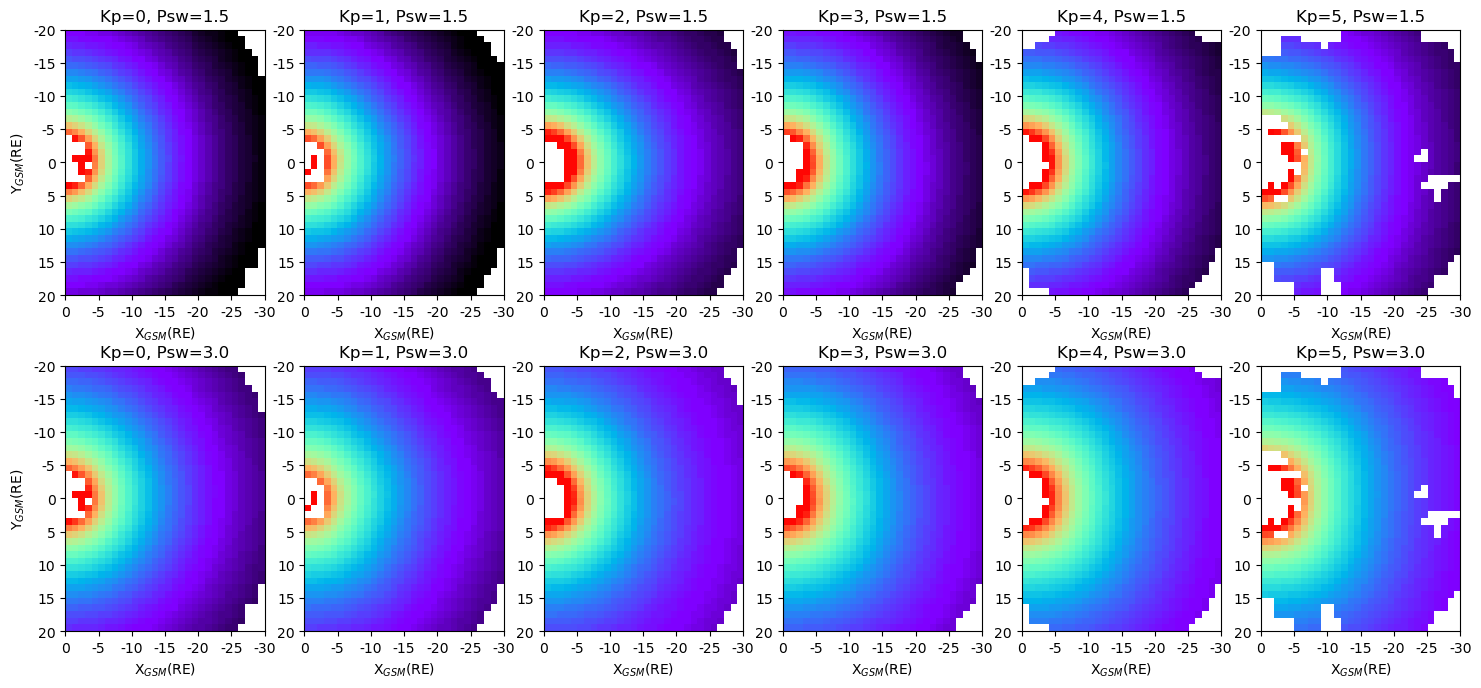

In [19]:
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

cmap_rainbow_black = plt.cm.rainbow
black = np.array((0.0, 0.0, 0.0))
num_steps = 100
colors_rainbow = [cmap_rainbow_black(i/num_steps)[:-1] for i in range(num_steps)]
num_steps = 20
colors_rainbow_black = [
    tuple((black * (num_steps - i) / num_steps + np.array(colors_rainbow[0]) * i / num_steps).tolist()) 
    for i in range(0, num_steps + 1)
] + colors_rainbow
norm = mcolors.LogNorm(vmin=0.1, vmax=10)
cmap = mcolors.ListedColormap(colors_rainbow_black)

def plt_setinfos(title, y_label=False):
    plt.title(title)
    plt.xlabel('X$_{GSM}$(RE)')
    if y_label:
        plt.ylabel('Y$_{GSM}$(RE)')
    plt.xlim(-0.5, 29.5)
    plt.ylim(-0.5, 39.5)
    plt.xticks(np.arange(-0.5, 30.5, 5), np.arange(-30, 1, 5))
    plt.yticks(np.arange(-0.5,40.5,5), np.arange(-20,21,5))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    

plt.figure(figsize=(3*6,4*2))
for i in range(2):
    for j in range(6):
        plt.subplot(2, 6, i*6+j+1)
        grid_size = (40, 30)
        grid_data = np.zeros(grid_size)
        x = x_total[i+j*2][:,0]
        y = x_total[i+j*2][:,1]
        pred = pred_func[i+j*2](np.sqrt(x ** 2 + y ** 2), np.arctan2(-y, -x))
        for ((_x, _y), _val) in zip(x_total[i+j*2], pred):
            grid_data[math.floor(_y)+20, math.floor(_x)+30] = max(1e-5,_val)
        plt.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
        title = f"Kp={j}, Psw={i*1.5+1.5}"
        plt_setinfos(title, True if j == 0 else False)

plt.show()

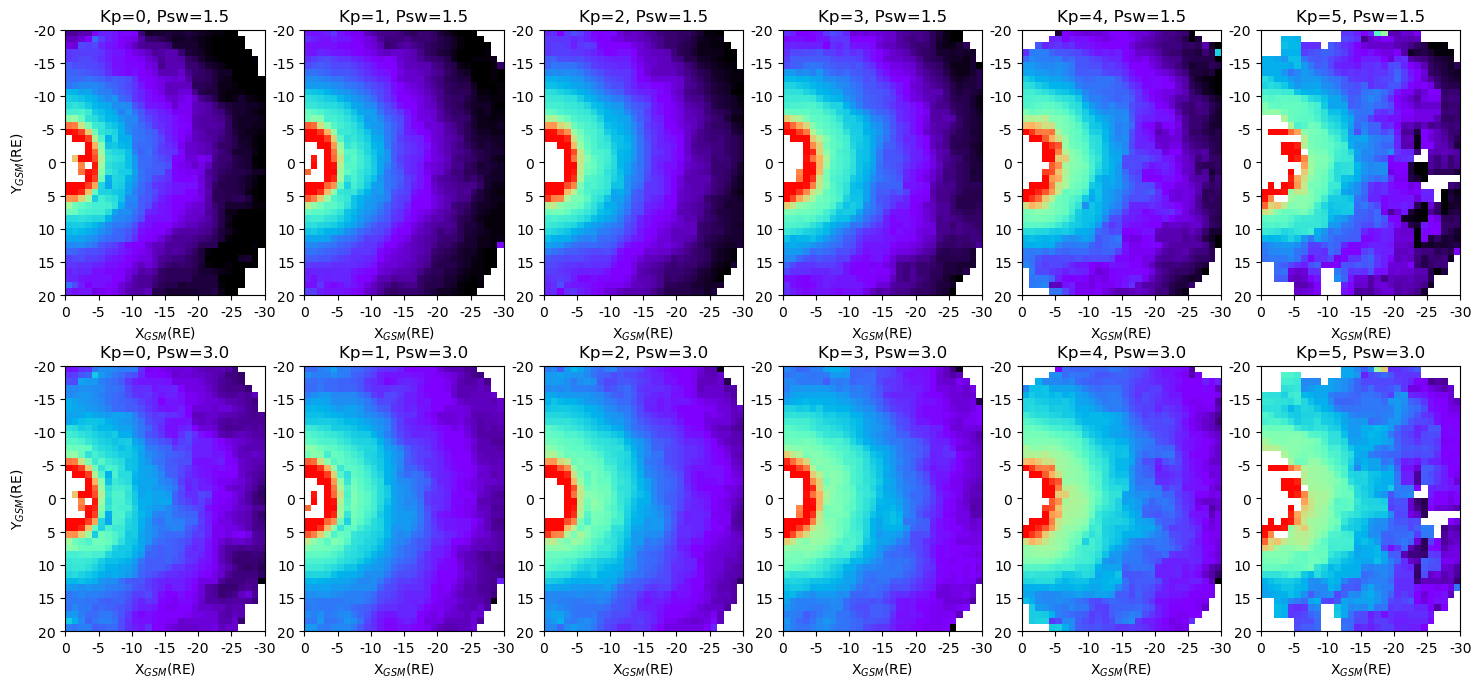

In [20]:
plt.figure(figsize=(3*6,4*2))
for i in range(2):
    for j in range(6):
        plt.subplot(2, 6, i*6+j+1)
        grid_size = (40, 30)
        grid_data = np.zeros(grid_size)
        for ((_x, _y), _val) in zip(x_total[i+j*2], y_total[i+j*2]):
            grid_data[math.floor(_y)+20, math.floor(_x)+30] = _val
        plt.imshow(grid_data, cmap=cmap, norm=norm, origin='lower')
        title = f"Kp={j}, Psw={i*1.5+1.5}"
        plt_setinfos(title, True if j == 0 else False)
plt.show()